# Reinforcement learning - Final project demo notebook
## Nir Weingarten - ID 302528435

In [1]:
!git clone https://github.com/hopl1t/sokoban_rl.git

Cloning into 'sokoban_rl'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 329 (delta 225), reused 229 (delta 125), pack-reused 0
Receiving objects: 100% (329/329), 1.20 MiB | 670.00 KiB/s, done.
Resolving deltas: 100% (225/225), done.


In [ ]:
!cd sokoban_rl && git pull

Already up to date.


In [2]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
!pip install gym[box2d]
!pip install gym_sokoban
import os
os.chdir('sokoban_rl')
import time
import pandas as pd
from a2c_agent import *
from dqn_agent import *
import pickle
from models import *
import utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 0s (2,923 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Th

In [3]:
def moving_average(iterable, window):
    averages = []
    for i in range(1, len(iterable)):
        averages.append(np.mean(iterable[max(0, i-window):i]))
    return averages

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def plot_results(all_episode_rewards, title, window=100):
    window = 100
    fig, axes = plt.subplots(1, 1, figsize=(15, 7))
    axes.plot(all_episode_rewards)
    axes.plot(moving_average(all_episode_rewards, window=window))
    _ = axes.set_title('All episode rewards', fontsize=14)
    _ = axes.legend(['sum of reward per episode','moving average over {} eisodes'
                    .format(window)])
    _ = axes.set_xlabel('episode', fontsize=14)
    _ = axes.set_ylabel('rewards', fontsize=14)
    _ = fig.suptitle(title, fontsize=18)

## Lunar lander
In this section different agents and models are used to learn Lunar Lander

All agents are trained using the 'cone trick' and various tuned hyperparameters

Environment is Lunar lander continuous v2

In [ ]:
all_agents = {}

### A2C setting 1 - discretisized action space
Action space is automatically split into 2X15 discrete actions (13 per axis)

In [ ]:
!rm -r ./saved_agents/a2c_1 
!mkdir ./saved_agents/a2c_1 && python trainer.py -env LunarLanderContinuous-v2 -model DiscreteActorCritic -epochs 3000 -obs_type BOX2D -action_type DISCRETIZIED  -print_interval 100 -eval_interval 400 -save_dir ./saved_agents/a2c_1 -log_dir . -log_interval 0 -lr 0.005 -num_discrete 15 -scheduler_gamma 0.75 -scheduler_interval 300 -hidden_size 256 -beta 0.003
with open(glob.glob('./saved_agents/a2c_1/*')[0], 'rb') as f:
    agent = pickle.load(f)
all_agents['a2c discretisized'] = agent

Using CUDA
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -561.633	min: -970.027		max: -306.639		%completed levels (sokoban only): 0.000
eps: 100, stats for last 100 eps:	avg eps reward: -293.598		avg eps step reward: -1.858		avg eps length: 157.080	 avg time: 0.251	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -165.288		avg eps step reward: -0.949		avg eps length: 174.250	 avg time: 0.288	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -59.639		avg eps step reward: -0.298		avg eps length: 199.870	 avg time: 0.372	tricks_used:0
stepped scheduler, new lr: 0.00375
eps: 400, stats for last 100 eps:	avg eps reward: 34.520		avg eps step reward: 0.150		avg eps length: 230.280	 avg time: 0.389	tricks_used:0
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -102.587	min: -309.462		max: 142.316		%completed levels (sokoban only): 0.000
eps: 500, stats for last 100 eps:	avg eps reward: -39.479		avg eps step reward: -

### A2C setting 2 - fixed action space
Action space is 8 pre defined action tuples

In [ ]:
!rm -r ./saved_agents/a2c_2
!mkdir ./saved_agents/a2c_2 && python trainer.py -env LunarLanderContinuous-v2 -model CommonActorCritic -epochs 3000 -obs_type BOX2D -action_type FIXED_LUNAR -print_interval 100 -eval_interval 400 -save_dir ./saved_agents/a2c_2 -log_dir . -log_interval 0 -lr 0.005 -num_discrete 15 -scheduler_gamma 0.75 -scheduler_interval 400 -hidden_size 256 -beta 0.003
with open(glob.glob('./saved_agents/a2c_2/*')[0], 'rb') as f:
    agent = pickle.load(f)
all_agents['a2c fixed'] = agent

Using CUDA
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -188.917	min: -403.082		max: -47.648		%completed levels (sokoban only): 0.000
eps: 100, stats for last 100 eps:	avg eps reward: -114.947		avg eps step reward: -0.857		avg eps length: 133.180	 avg time: 0.189	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -103.364		avg eps step reward: -0.662		avg eps length: 156.050	 avg time: 0.227	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -88.331		avg eps step reward: -0.728		avg eps length: 121.390	 avg time: 0.157	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -14.908		avg eps step reward: -0.076		avg eps length: 196.760	 avg time: 0.295	tricks_used:0
stepped scheduler, new lr: 0.00375
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -13.424	min: -244.751		max: 231.404		%completed levels (sokoban only): 0.000
eps: 500, stats for last 100 eps:	avg eps reward: 91.111		avg eps step reward: 0.

### A2C setting 3 - Gaussian action space
Action space is a pair of $(\mu,\sigma)$ tuples that is used to generate continuous action over both axes

In [ ]:
!rm -r ./saved_agents/a2c_3
!mkdir ./saved_agents/a2c_3 && python trainer.py -env LunarLanderContinuous-v2 -model GaussianActorCritic -epochs 3000 -obs_type BOX2D -action_type GAUSSIAN -print_interval 100 -save_dir ./saved_agents/a2c_3 -log_dir . -log_interval 0 -lr 0.001 -num_discrete 15 -scheduler_gamma 0.75 -scheduler_interval 800 -hidden_size 256 -beta 0.003
with open(glob.glob('./saved_agents/a2c_3/*')[0], 'rb') as f:
    agent = pickle.load(f)
all_agents['a2c gaussian'] = agent

Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -625.521		avg eps step reward: -4.221		avg eps length: 147.370	 avg time: 0.251	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -791.525		avg eps step reward: -5.902		avg eps length: 134.120	 avg time: 0.209	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -778.614		avg eps step reward: -5.911		avg eps length: 131.720	 avg time: 0.204	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -697.335		avg eps step reward: -5.151		avg eps length: 135.380	 avg time: 0.211	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -639.978		avg eps step reward: -4.798		avg eps length: 133.380	 avg time: 0.208	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -653.994		avg eps step reward: -4.736		avg eps length: 138.090	 avg time: 0.217	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -610.352		avg eps step reward: -4.811		avg eps length: 126.870	 avg time: 0

### A2C setting 4 - Convolutional NN model
Action space is discretisized like in the first trail only now to common layer is a 1D convolutional layer

In [ ]:
!rm -r ./saved_agents/a2c_4
!mkdir ./saved_agents/a2c_4 && python trainer.py -env LunarLanderContinuous-v2 -model DiscreteConvActorCritic -epochs 3000 -obs_type BOX2D -action_type DISCRETIZIED -print_interval 100 -eval_interval 400 -save_dir ./saved_agents/a2c_4 -log_dir . -log_interval 0 -lr 0.005 -num_discrete 13 -scheduler_gamma 0.75 -scheduler_interval 500 -hidden_size 256 -beta 0.003
with open(glob.glob('./saved_agents/a2c_4/*')[0], 'rb') as f:
    agent = pickle.load(f)
all_agents['a2c gaussian'] = agent

Using CUDA
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -826.696	min: -1465.293		max: -468.829		%completed levels (sokoban only): 0.000
eps: 100, stats for last 100 eps:	avg eps reward: -343.394		avg eps step reward: -2.508		avg eps length: 135.800	 avg time: 0.241	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -180.923		avg eps step reward: -1.574		avg eps length: 114.920	 avg time: 0.197	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -128.709		avg eps step reward: -1.093		avg eps length: 117.790	 avg time: 0.221	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -465.500		avg eps step reward: -6.942		avg eps length: 67.060	 avg time: 0.104	tricks_used:0
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -468.764	min: -812.062		max: -227.510		%completed levels (sokoban only): 0.000
eps: 500, stats for last 100 eps:	avg eps reward: -460.738		avg eps step reward: -6.987		avg eps length: 65.940

### DQN setting 1 - Epsilon greedy + use PER
Action space is a fixed set, training epsilon greedy and PER

In [ ]:
!rm -r ./saved_agents/dqn_1
!mkdir ./saved_agents/dqn_1 && python trainer.py -env LunarLanderContinuous-v2 -model SimpleDQN -agent DQNAgent -epochs 3000 -obs_type BOX2D -action_type FIXED_LUNAR -print_interval 100 -eval_interval 400 -save_dir ./saved_agents/dqn_1 -log_dir . -log_interval 0 -lr 0.002 -num_discrete 15 -scheduler_gamma 0.75 -scheduler_interval 600 -hidden_size 512 -beta 0.003 -epsilon 1 -epsilon_decay 0.999
with open(glob.glob('./saved_agents/dqn_1/*')[0], 'rb') as f:
    agent = pickle.load(f)
all_agents['dqn epsilon greedy using PER'] = agent

Using CUDA
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -569.967	min: -1178.830		max: -325.050		%completed levels (sokoban only): 0.000
eps: 100, stats for last 100 eps:	avg eps reward: -200.112		avg eps step reward: -1.837		avg eps length: 107.910	 avg time: 0.108	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -192.358		avg eps step reward: -1.571		avg eps length: 122.470	 avg time: 0.129	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -182.949		avg eps step reward: -1.425		avg eps length: 128.370	 avg time: 0.150	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -162.269		avg eps step reward: -0.973		avg eps length: 166.700	 avg time: 0.224	tricks_used:0
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -125.671	min: -255.197		max: 74.948		%completed levels (sokoban only): 0.000
eps: 500, stats for last 100 eps:	avg eps reward: -139.441		avg eps step reward: -0.563		avg eps length: 247.650

### DQN setting 2 - Epsilon soft + use PER
Action space is a fixed set, training epsilon soft and PER

In [ ]:
!rm -r ./saved_agents/dqn_2
!mkdir ./saved_agents/dqn_2 && python trainer.py -env LunarLanderContinuous-v2 -model SimpleDQN -agent DQNAgent -epochs 3000 -obs_type BOX2D -action_type FIXED_LUNAR -print_interval 100 -eval_interval 400 -save_dir ./saved_agents/dqn_2 -log_dir . -log_interval 0 -lr 0.002 -num_discrete 15 -scheduler_gamma 0.75 -scheduler_interval 700 -hidden_size 512 -beta 0.003
with open(glob.glob('./saved_agents/dqn_2/*')[0], 'rb') as f:
    agent = pickle.load(f)
all_agents['dqn epsilon soft using PER'] = agent

Using CUDA
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -227.578	min: -477.059		max: 11.336		%completed levels (sokoban only): 0.000
eps: 100, stats for last 100 eps:	avg eps reward: -275.443		avg eps step reward: -2.916		avg eps length: 93.460	 avg time: 0.106	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -125.605		avg eps step reward: -1.824		avg eps length: 68.880	 avg time: 0.063	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -126.360		avg eps step reward: -1.833		avg eps length: 68.950	 avg time: 0.063	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -130.690		avg eps step reward: -1.896		avg eps length: 68.940	 avg time: 0.062	tricks_used:0
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -130.239	min: -314.349		max: 35.144		%completed levels (sokoban only): 0.000
eps: 500, stats for last 100 eps:	avg eps reward: -134.053		avg eps step reward: -1.948		avg eps length: 68.820	 avg ti

### DQN setting 3 - Epsilon greedy + no PER
Action space is a fixed set, training epsilon greedy without PER

In [33]:
!rm -r ./saved_agents/dqn_3
!mkdir ./saved_agents/dqn_3 && python trainer.py -env LunarLanderContinuous-v2 -model SimpleDQN -agent DQNAgent -epochs 3000 -obs_type BOX2D -action_type FIXED_LUNAR -print_interval 100 -eval_interval 400 -save_dir ./saved_agents/dqn_3 -log_dir . -log_interval 0 -lr 0.002 -num_discrete 15 -scheduler_gamma 0.75 -scheduler_interval 700 -hidden_size 512 -beta 0.003 -epsilon 1 -epsilon_decay 0.999 -no_PER
with open(glob.glob('./saved_agents/dqn_3/*')[0], 'rb') as f:
    agent = pickle.load(f)
all_agents['dqn epsilon greedy not using PER'] = agent

Using CUDA
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -643.451	min: -818.609		max: -477.363		%completed levels (sokoban only): 0.000
eps: 100, stats for last 100 eps:	avg eps reward: -213.175		avg eps step reward: -2.015		avg eps length: 104.520	 avg time: 0.094	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -197.115		avg eps step reward: -1.843		avg eps length: 106.930	 avg time: 0.094	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -167.638		avg eps step reward: -1.430		avg eps length: 117.220	 avg time: 0.108	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -109.332		avg eps step reward: -0.587		avg eps length: 186.400	 avg time: 0.216	tricks_used:0
********** Evaluation **********
Evaluation on last 100 episodes:	mean: -19.912	min: -227.885		max: 209.650		%completed levels (sokoban only): 0.000
eps: 500, stats for last 100 eps:	avg eps reward: -131.539		avg eps step reward: -0.534		avg eps length: 246.220	

In [35]:
with open('/content/drive/MyDrive/RL_project/saved_agents/agent_dict.pkl', 'wb') as f:
    pickle.dump(all_agents, f)

### Visualization of resutls
We present a comparison of the 4 best trained agents divided into categories A2C and DQN

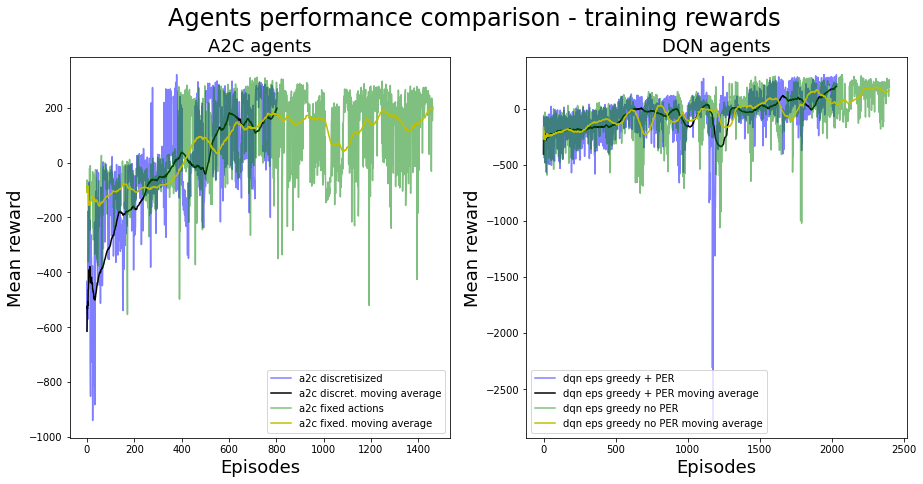

In [57]:
WINDOW = 100
COLORS = ['b', 'g', 'c', 'm', 'y', 'k']
fig, axes = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Agents performance comparison - training rewards', fontsize=24)
axes[0].set_title('A2C agents', fontsize=18)
axes[1].set_title('DQN agents', fontsize=18)
axes[0].set_xlabel('Episodes', fontsize=18)
axes[0].set_ylabel('Mean reward', fontsize=18)
axes[1].set_xlabel('Episodes', fontsize=18)
axes[1].set_ylabel('Mean reward', fontsize=18)
a2c_agents = [all_agents['a2c discretisized'], all_agents['a2c fixed']]
dqn_agents = [all_agents['dqn epsilon greedy using PER'], 
              all_agents['dqn epsilon greedy not using PER']]

for i, (a2c_agent, dqn_agent) in enumerate(zip(a2c_agents, dqn_agents)):
    axes[0].plot(a2c_agent.all_rewards, color=COLORS[i], alpha=0.5)
    axes[0].plot(moving_average(a2c_agent.all_rewards, window=WINDOW),
                 color=COLORS[::-1][i])
    axes[1].plot(dqn_agent.all_rewards, color=COLORS[i], alpha=0.5)
    axes[1].plot(moving_average(dqn_agent.all_rewards, window=WINDOW),
                 color=COLORS[::-1][i])
_ = axes[0].legend(['a2c discretisized', 'a2c discret. moving average',
                'a2c fixed actions', 'a2c fixed. moving average'])
_ = axes[1].legend(['dqn eps greedy + PER', 'dqn eps greedy + PER moving average',
                'dqn eps greedy no PER', 'dqn eps greedy no PER moving average'])

#### We proceed to display results of the best a2c model in validation mode
This includes a graph over 300 new episodes over a greedy policy and an episode video

In [58]:
all_rewards, all_episode_rewards, _ = utils.evaluate(
    agent=all_agents['a2c discretisized'],
    num_episodes=300,
    render=False)

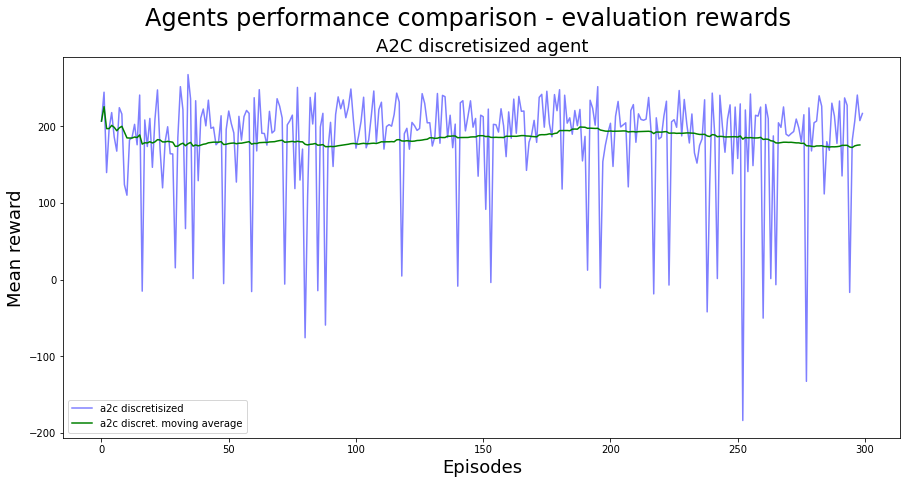

In [61]:
WINDOW = 100
COLORS = ['b', 'g', 'c', 'm', 'y', 'k']
a2c_agent = all_agents['a2c discretisized']
fig, axes = plt.subplots(1, 1, figsize=(15,7))
fig.suptitle('Agents performance comparison - evaluation rewards', fontsize=24)
axes.set_title('A2C discretisized agent', fontsize=18)
axes.set_xlabel('Episodes', fontsize=18)
axes.set_ylabel('Mean reward', fontsize=18)
axes.plot(all_episode_rewards, color=COLORS[0], alpha=0.5)
axes.plot(moving_average(all_episode_rewards, window=WINDOW),color=COLORS[1])
_ = axes.legend(['a2c discretisized', 'a2c discret. moving average'])

In [5]:
all_rewards, all_episode_rewards, _ = utils.evaluate(
    agent=a2c_agent, num_episodes=1, render=True)
print('played episode reward: {}'.format(all_episode_rewards[0]))
show_video()

Saving render video to /content/sokoban_rl/video
played episode reward: 195.33726035441777


## Sokoban
As Sokoban training is very long it has been done is a seperate notebook.
We include here only the results and the visualizaiton
Environment is Sokoban Push&Pull 

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -227.291		avg eps step reward: -inf		avg eps length: 125.460	 avg time: 0.161	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -325.297		avg eps step reward: -inf		avg eps length: 102.850	 avg time: 0.127	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -129.287		avg eps step reward: -inf		avg eps length: 149.370	 avg time: 0.223	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -118.676		avg eps step reward: -inf		avg eps length: 187.610	 avg time: 0.266	tricks_used:0
stepped scheduler, new lr: 0.00075
eps: 500, stats for last 100 eps:	avg eps reward: -89.629		avg eps step reward: -inf		avg eps length: 185.950	 avg time: 0.272	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -90.339		avg eps step reward: -inf		avg eps length: 194.680	 avg time: 0.313	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -154.911		avg eps step reward: -inf		avg eps length: 169.950	 avg

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False, epsilon=1)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -249.591		avg eps step reward: -inf		avg eps length: 117.380	 avg time: 0.123	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -236.337		avg eps step reward: -inf		avg eps length: 105.770	 avg time: 0.106	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -217.762		avg eps step reward: -inf		avg eps length: 311.270	 avg time: 0.588	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -169.792		avg eps step reward: -inf		avg eps length: 638.020	 avg time: 1.370	tricks_used:0
stepped scheduler, new lr: 0.00075
eps: 500, stats for last 100 eps:	avg eps reward: -110.978		avg eps step reward: -inf		avg eps length: 894.200	 avg time: 2.195	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -111.565		avg eps step reward: -inf		avg eps length: 1000.000	 avg time: 2.617	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -107.695		avg eps step reward: -inf		avg eps length: 1000.000	

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=True)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -316.558		avg eps step reward: -inf		avg eps length: 107.920	 avg time: 0.113	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -162.988		avg eps step reward: -inf		avg eps length: 68.940	 avg time: 0.060	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -134.685		avg eps step reward: -inf		avg eps length: 69.940	 avg time: 0.059	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -130.283		avg eps step reward: -inf		avg eps length: 67.650	 avg time: 0.057	tricks_used:0
stepped scheduler, new lr: 0.00075
eps: 500, stats for last 100 eps:	avg eps reward: -132.779		avg eps step reward: -inf		avg eps length: 69.100	 avg time: 0.059	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -133.818		avg eps step reward: -inf		avg eps length: 71.910	 avg time: 0.060	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -145.951		avg eps step reward: -inf		avg eps length: 72.420	 avg tim

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 128
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=True)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -214.921		avg eps step reward: -inf		avg eps length: 118.460	 avg time: 0.126	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -270.255		avg eps step reward: -inf		avg eps length: 119.870	 avg time: 0.125	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -201.300		avg eps step reward: -inf		avg eps length: 126.260	 avg time: 0.137	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -205.787		avg eps step reward: -inf		avg eps length: 260.200	 avg time: 0.407	tricks_used:0
stepped scheduler, new lr: 0.00075
eps: 500, stats for last 100 eps:	avg eps reward: -103.970		avg eps step reward: -inf		avg eps length: 433.910	 avg time: 0.819	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: 3.660		avg eps step reward: inf		avg eps length: 570.180	 avg time: 1.045	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: 47.760		avg eps step reward: inf		avg eps length: 832.260	 avg time

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.0035
SCHED_GAMMA = 0.8
HIDDEN_SIZE = 512
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=True)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -225.845		avg eps step reward: -inf		avg eps length: 175.080	 avg time: 0.221	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -105.534		avg eps step reward: -inf		avg eps length: 184.540	 avg time: 0.242	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -64.159		avg eps step reward: -inf		avg eps length: 174.720	 avg time: 0.223	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -66.430		avg eps step reward: -inf		avg eps length: 147.980	 avg time: 0.170	tricks_used:0
stepped scheduler, new lr: 0.00280
eps: 500, stats for last 100 eps:	avg eps reward: -93.949		avg eps step reward: -inf		avg eps length: 177.810	 avg time: 0.221	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -40.684		avg eps step reward: -inf		avg eps length: 194.380	 avg time: 0.258	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -46.248		avg eps step reward: -inf		avg eps length: 164.470	 avg ti

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.0035
SCHED_GAMMA = 0.8
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=True)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -217.372		avg eps step reward: -inf		avg eps length: 136.240	 avg time: 0.163	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -156.969		avg eps step reward: -inf		avg eps length: 82.120	 avg time: 0.080	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -135.179		avg eps step reward: -inf		avg eps length: 71.940	 avg time: 0.060	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -133.270		avg eps step reward: -inf		avg eps length: 69.990	 avg time: 0.060	tricks_used:0
stepped scheduler, new lr: 0.00280
eps: 500, stats for last 100 eps:	avg eps reward: -134.827		avg eps step reward: -inf		avg eps length: 69.730	 avg time: 0.059	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -132.908		avg eps step reward: -inf		avg eps length: 71.600	 avg time: 0.061	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -127.682		avg eps step reward: -inf		avg eps length: 68.260	 avg tim

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.0035
SCHED_GAMMA = 0.8
HIDDEN_SIZE = 512
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -235.185		avg eps step reward: -inf		avg eps length: 79.250	 avg time: 0.088	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -145.460		avg eps step reward: -inf		avg eps length: 69.330	 avg time: 0.076	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -141.458		avg eps step reward: -inf		avg eps length: 66.810	 avg time: 0.072	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -141.392		avg eps step reward: -inf		avg eps length: 69.320	 avg time: 0.075	tricks_used:0
stepped scheduler, new lr: 0.00280
eps: 500, stats for last 100 eps:	avg eps reward: -135.276		avg eps step reward: -inf		avg eps length: 70.520	 avg time: 0.076	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -123.862		avg eps step reward: -inf		avg eps length: 68.610	 avg time: 0.074	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -124.317		avg eps step reward: -inf		avg eps length: 70.710	 avg time

In [ ]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.0035
SCHED_GAMMA = 0.8
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -228.001		avg eps step reward: -inf		avg eps length: 87.010	 avg time: 0.091	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -175.404		avg eps step reward: -inf		avg eps length: 69.170	 avg time: 0.066	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -160.167		avg eps step reward: -inf		avg eps length: 70.560	 avg time: 0.076	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -134.477		avg eps step reward: -inf		avg eps length: 68.740	 avg time: 0.075	tricks_used:0
stepped scheduler, new lr: 0.00280
eps: 500, stats for last 100 eps:	avg eps reward: -131.681		avg eps step reward: -inf		avg eps length: 68.930	 avg time: 0.075	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -134.555		avg eps step reward: -inf		avg eps length: 71.590	 avg time: 0.077	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -135.242		avg eps step reward: -inf		avg eps length: 70.360	 avg time

## NEW!!

In [ ]:
# lower lr
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.0005
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False, epsilon=1)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -220.799		avg eps step reward: -inf		avg eps length: 108.010	 avg time: 0.107	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -331.831		avg eps step reward: -inf		avg eps length: 106.230	 avg time: 0.105	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -259.886		avg eps step reward: -inf		avg eps length: 105.970	 avg time: 0.107	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -221.476		avg eps step reward: -inf		avg eps length: 146.200	 avg time: 0.183	tricks_used:0
stepped scheduler, new lr: 0.00040
eps: 500, stats for last 100 eps:	avg eps reward: -132.844		avg eps step reward: -inf		avg eps length: 157.290	 avg time: 0.189	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -161.153		avg eps step reward: -inf		avg eps length: 204.700	 avg time: 0.311	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -235.927		avg eps step reward: -inf		avg eps length: 252.160	 a

In [ ]:
# cone trick #### DEBUG THIS!!
num_iterations = 1
CONE_TRICK = True
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 0
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False, epsilon=1)

#################### Attempt 0  ####################
Using CUDA


/content/sokoban_rl/utils.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -244.862		avg eps step reward: -inf		avg eps length: 98.090	 avg time: 0.099	tricks_used:0


KeyboardInterrupt: ignored

In [ ]:
# higher epsilon decay
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False, epsilon=1, epsilon_decay=0.999)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -206.279		avg eps step reward: -inf		avg eps length: 104.730	 avg time: 0.086	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -235.508		avg eps step reward: -inf		avg eps length: 120.310	 avg time: 0.103	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -206.349		avg eps step reward: -inf		avg eps length: 135.280	 avg time: 0.123	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -182.634		avg eps step reward: -inf		avg eps length: 205.170	 avg time: 0.261	tricks_used:0
stepped scheduler, new lr: 0.00075
eps: 500, stats for last 100 eps:	avg eps reward: -246.863		avg eps step reward: -inf		avg eps length: 186.790	 avg time: 0.247	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -105.954		avg eps step reward: -inf		avg eps length: 445.590	 avg time: 0.898	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -75.504		avg eps step reward: -inf		avg eps length: 570.220	 av

In [ ]:
# lower schedular
SCHED_GAMMA = 0.9 #0.75
SCHED_INTERVAL = 400
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False, epsilon=1)


#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -242.276		avg eps step reward: -inf		avg eps length: 118.050	 avg time: 0.103	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -270.617		avg eps step reward: -inf		avg eps length: 122.360	 avg time: 0.136	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -170.206		avg eps step reward: -inf		avg eps length: 567.490	 avg time: 1.368	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -115.553		avg eps step reward: -inf		avg eps length: 595.720	 avg time: 1.473	tricks_used:0
stepped scheduler, new lr: 0.00090
eps: 500, stats for last 100 eps:	avg eps reward: -70.901		avg eps step reward: -inf		avg eps length: 903.580	 avg time: 2.428	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -91.663		avg eps step reward: -inf		avg eps length: 1000.000	 avg time: 2.754	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -83.290		avg eps step reward: -inf		avg eps length: 1000.000	 av

In [ ]:
# 512
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 512
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False, epsilon=1)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -230.689		avg eps step reward: -inf		avg eps length: 109.030	 avg time: 0.103	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -187.740		avg eps step reward: -inf		avg eps length: 165.700	 avg time: 0.188	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -163.410		avg eps step reward: -inf		avg eps length: 423.310	 avg time: 0.841	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -120.803		avg eps step reward: -inf		avg eps length: 647.880	 avg time: 1.532	tricks_used:0
stepped scheduler, new lr: 0.00090
eps: 500, stats for last 100 eps:	avg eps reward: -98.357		avg eps step reward: -inf		avg eps length: 997.370	 avg time: 2.887	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -87.544		avg eps step reward: -inf		avg eps length: 1000.000	 avg time: 2.900	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -80.048		avg eps step reward: -inf		avg eps length: 840.840	 avg

In [ ]:
# higher learning rate
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.0035
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='FIXED_LUNAR', no_per=False, epsilon=1)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -230.653		avg eps step reward: -inf		avg eps length: 111.940	 avg time: 0.096	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -214.042		avg eps step reward: -inf		avg eps length: 157.530	 avg time: 0.192	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -132.706		avg eps step reward: -inf		avg eps length: 282.340	 avg time: 0.492	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -94.951		avg eps step reward: -inf		avg eps length: 526.030	 avg time: 1.124	tricks_used:0
stepped scheduler, new lr: 0.00315
eps: 500, stats for last 100 eps:	avg eps reward: -143.517		avg eps step reward: -inf		avg eps length: 930.740	 avg time: 2.314	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -130.326		avg eps step reward: -inf		avg eps length: 722.890	 avg time: 1.999	tricks_used:0
eps: 700, stats for last 100 eps:	avg eps reward: -133.185		avg eps step reward: -inf		avg eps length: 458.260	 av

In [ ]:
num_iterations = 2
CONE_TRICK = True
NUM_DISCRETE = 13
LR = 0.005
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 500
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscreteActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1500,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -292.315		avg eps step reward: -2.403		avg eps length: 120.240	 avg time: 0.203	tricks_used:43
eps: 200, stats for last 100 eps:	avg eps reward: -131.252		avg eps step reward: -0.811		avg eps length: 161.850	 avg time: 0.300	tricks_used:44
eps: 300, stats for last 100 eps:	avg eps reward: -89.489		avg eps step reward: -0.151		avg eps length: 591.720	 avg time: 2.206	tricks_used:34
eps: 400, stats for last 100 eps:	avg eps reward: 2.085		avg eps step reward: 0.003		avg eps length: 694.200	 avg time: 2.633	tricks_used:20
stepped scheduler, new lr: 0.00375
Stopped using trick
eps: 500, stats for last 100 eps:	avg eps reward: 73.145		avg eps step reward: 0.082		avg eps length: 893.770	 avg time: 2.807	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: 90.859		avg eps step reward: 0.119		avg eps length: 760.490	 avg time: 2.069	tricks_used:0
eps: 700, stats for last

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.005
HIDDEN_SIZE = 1024
CLIP_GRADIENT = False
STOP_TRICK_AT = 500
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscreteActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1500,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -308.957		avg eps step reward: -1.688		avg eps length: 181.990	 avg time: 0.323	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -56.610		avg eps step reward: -0.206		avg eps length: 274.730	 avg time: 0.748	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -144.659		avg eps step reward: -0.994		avg eps length: 145.510	 avg time: 0.263	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -130.743		avg eps step reward: -1.346		avg eps length: 97.100	 avg time: 0.137	tricks_used:0
stepped scheduler, new lr: 0.00375
Stopped using trick
eps: 500, stats for last 100 eps:	avg eps reward: -142.278		avg eps step reward: -0.521		avg eps length: 273.140	 avg time: 0.810	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -83.834		avg eps step reward: -0.207		avg eps length: 404.840	 avg time: 1.454	tricks_used:0
eps: 700, stats for 

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 15
LR = 0.005
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscreteActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1500,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -330.065		avg eps step reward: -2.175		avg eps length: 150.580	 avg time: 0.257	tricks_used:0
Stopped using trick
eps: 200, stats for last 100 eps:	avg eps reward: -146.004		avg eps step reward: -0.466		avg eps length: 313.330	 avg time: 0.917	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -106.762		avg eps step reward: -0.531		avg eps length: 201.160	 avg time: 0.600	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -71.681		avg eps step reward: -0.218		avg eps length: 328.170	 avg time: 0.976	tricks_used:0
stepped scheduler, new lr: 0.00375
eps: 500, stats for last 100 eps:	avg eps reward: 9.590		avg eps step reward: 0.046		avg eps length: 210.320	 avg time: 0.429	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: 151.395		avg eps step reward: 0.517		avg eps length: 292.840	 avg time: 0.600	tricks_used:0
eps: 700, stats for last

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.005
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscreteConvActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1500,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -446.631		avg eps step reward: -2.962		avg eps length: 149.540	 avg time: 0.299	tricks_used:0
Stopped using trick
eps: 200, stats for last 100 eps:	avg eps reward: -114.849		avg eps step reward: -0.698		avg eps length: 164.610	 avg time: 0.337	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -55.616		avg eps step reward: -0.310		avg eps length: 179.210	 avg time: 0.421	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -149.696		avg eps step reward: -0.423		avg eps length: 354.300	 avg time: 1.175	tricks_used:0
stepped scheduler, new lr: 0.00375
eps: 500, stats for last 100 eps:	avg eps reward: -123.188		avg eps step reward: -1.021		avg eps length: 120.660	 avg time: 0.245	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -5.074		avg eps step reward: -0.013		avg eps length: 394.890	 avg time: 1.107	tricks_used:0
eps: 700, stats for 

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.005
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(GaussianActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1500,
                           action_type='GAUSSIAN', no_per=False)

#################### Attempt 0  ####################
Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -517.867		avg eps step reward: -7.104		avg eps length: 70.500	 avg time: 0.108	tricks_used:0
Stopped using trick
eps: 200, stats for last 100 eps:	avg eps reward: -235.720		avg eps step reward: -3.273		avg eps length: 72.010	 avg time: 0.102	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -121.952		avg eps step reward: -1.796		avg eps length: 67.900	 avg time: 0.093	tricks_used:0
eps: 400, stats for last 100 eps:	avg eps reward: -122.091		avg eps step reward: -1.742		avg eps length: 70.090	 avg time: 0.096	tricks_used:0
stepped scheduler, new lr: 0.00375
eps: 500, stats for last 100 eps:	avg eps reward: -136.753		avg eps step reward: -1.968		avg eps length: 69.490	 avg time: 0.098	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -121.068		avg eps step reward: -1.754		avg eps length: 69.020	 avg time: 0.096	tricks_used:0
eps: 700, stats for las

ValueError: ignored

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 3
LR = 0.001
HIDDEN_SIZE = 128
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -373.009		avg eps step reward: -inf		avg eps length: 100.030	 avg time: 0.194	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -209.462		avg eps step reward: -inf		avg eps length: 73.620	 avg time: 0.122	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -132.714		avg eps step reward: -inf		avg eps length: 69.570	 avg time: 0.109	tricks_used:0
stepped scheduler, new lr: 0.00097
eps: 400, stats for last 100 eps:	avg eps reward: -153.295		avg eps step reward: -inf		avg eps length: 72.840	 avg time: 0.116	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -197.949		avg eps step reward: -inf		avg eps length: 69.390	 avg time: 0.111	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -149.781		avg eps step reward: -inf		avg eps length: 71.160	 avg time: 0.111	tricks_used:0
stepped scheduler, new lr: 0.00094
eps: 700, stats for last 100 eps:	avg eps reward: -336.707		avg eps step reward: -i

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 7
LR = 0.001
HIDDEN_SIZE = 128
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -442.770		avg eps step reward: -inf		avg eps length: 129.960	 avg time: 0.268	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -419.435		avg eps step reward: -inf		avg eps length: 191.650	 avg time: 0.500	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -298.971		avg eps step reward: -inf		avg eps length: 130.510	 avg time: 0.266	tricks_used:0
stepped scheduler, new lr: 0.00097
eps: 400, stats for last 100 eps:	avg eps reward: -227.969		avg eps step reward: -inf		avg eps length: 186.440	 avg time: 0.452	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -300.290		avg eps step reward: -inf		avg eps length: 181.700	 avg time: 0.424	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -255.577		avg eps step reward: -inf		avg eps length: 237.520	 avg time: 0.612	tricks_used:0
stepped scheduler, new lr: 0.00094
eps: 700, stats for last 100 eps:	avg eps reward: -262.306		avg eps step rewar

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 3
LR = 0.0003
HIDDEN_SIZE = 128
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -313.729		avg eps step reward: -inf		avg eps length: 100.390	 avg time: 0.178	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -299.113		avg eps step reward: -inf		avg eps length: 81.640	 avg time: 0.135	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -128.652		avg eps step reward: -inf		avg eps length: 71.000	 avg time: 0.107	tricks_used:0
stepped scheduler, new lr: 0.00029
eps: 400, stats for last 100 eps:	avg eps reward: -130.732		avg eps step reward: -inf		avg eps length: 70.550	 avg time: 0.108	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -134.611		avg eps step reward: -inf		avg eps length: 69.160	 avg time: 0.103	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -135.598		avg eps step reward: -inf		avg eps length: 70.070	 avg time: 0.104	tricks_used:0
stepped scheduler, new lr: 0.00028
eps: 700, stats for last 100 eps:	avg eps reward: -132.322		avg eps step reward: -i

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 7
LR = 0.001
HIDDEN_SIZE = 512
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -318.215		avg eps step reward: -inf		avg eps length: 275.030	 avg time: 1.056	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -249.912		avg eps step reward: -inf		avg eps length: 360.460	 avg time: 1.474	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -190.455		avg eps step reward: -inf		avg eps length: 522.560	 avg time: 2.337	tricks_used:0
stepped scheduler, new lr: 0.00097
eps: 400, stats for last 100 eps:	avg eps reward: -145.993		avg eps step reward: -inf		avg eps length: 447.390	 avg time: 2.067	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -178.674		avg eps step reward: -inf		avg eps length: 523.940	 avg time: 2.452	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -225.149		avg eps step reward: -inf		avg eps length: 441.980	 avg time: 2.082	tricks_used:0
stepped scheduler, new lr: 0.00094
eps: 700, stats for last 100 eps:	avg eps reward: -373.610		avg eps step rewar

In [ ]:
num_iterations = 2
CONE_TRICK = True
NUM_DISCRETE = 7
LR = 0.001
HIDDEN_SIZE = 512
CLIP_GRADIENT = False
STOP_TRICK_AT = 400
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -383.676		avg eps step reward: -inf		avg eps length: 121.400	 avg time: 0.375	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -241.942		avg eps step reward: -inf		avg eps length: 175.700	 avg time: 0.625	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -394.952		avg eps step reward: -inf		avg eps length: 123.180	 avg time: 0.397	tricks_used:0
stepped scheduler, new lr: 0.00097
eps: 400, stats for last 100 eps:	avg eps reward: -412.239		avg eps step reward: -inf		avg eps length: 96.220	 avg time: 0.293	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -356.092		avg eps step reward: -inf		avg eps length: 77.900	 avg time: 0.224	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -137.742		avg eps step reward: -inf		avg eps length: 63.910	 avg time: 0.176	tricks_used:0
stepped scheduler, new lr: 0.00094
eps: 700, stats for last 100 eps:	avg eps reward: -152.216		avg eps step reward: 

In [ ]:
num_iterations = 2
CONE_TRICK = False
NUM_DISCRETE = 7
LR = 0.025
HIDDEN_SIZE = 512
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=3000,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CPU


/content/sokoban_rl/utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(agent.all_rewards[-print_interval:]) / steps_count,


eps: 100, stats for last 100 eps:	avg eps reward: -337.304		avg eps step reward: -inf		avg eps length: 86.780	 avg time: 0.236	tricks_used:0
eps: 200, stats for last 100 eps:	avg eps reward: -361.950		avg eps step reward: -inf		avg eps length: 71.410	 avg time: 0.196	tricks_used:0
eps: 300, stats for last 100 eps:	avg eps reward: -523.641		avg eps step reward: -inf		avg eps length: 76.110	 avg time: 0.220	tricks_used:0
stepped scheduler, new lr: 0.02425
eps: 400, stats for last 100 eps:	avg eps reward: -558.361		avg eps step reward: -inf		avg eps length: 96.770	 avg time: 0.283	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -598.467		avg eps step reward: -inf		avg eps length: 116.010	 avg time: 0.349	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -751.398		avg eps step reward: -inf		avg eps length: 101.860	 avg time: 0.321	tricks_used:0
stepped scheduler, new lr: 0.02352
eps: 700, stats for last 100 eps:	avg eps reward: -676.932		avg eps step reward: -

#### Train the best discrete agent


In [ ]:
# LR = 0.0035
LR = 0.005
HIDDEN_SIZE = 512
NUM_DISCRETE = 9
num_iterations = 2
CLIP_GRADIENT = True
STOP_TRICK_AT = 300
CONE_TRICK = True
pkl_save_path = os.path.join(DRIVE_PATH, 'best_discrete.pkl')
discrete_agents = find_best(SplitDiscreteActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1000,
                            action_type='DISCRETIZIED')

#################### Attempt 0  ####################
Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -705.631		avg eps step reward: -5.946		avg eps length: 117.830	 avg time: 0.213	tricks_used:61
eps: 200, stats for last 100 eps:	avg eps reward: -869.217		avg eps step reward: -4.614		avg eps length: 188.400	 avg time: 0.432	tricks_used:22
Stopped using trick
eps: 300, stats for last 100 eps:	avg eps reward: -524.987		avg eps step reward: -4.156		avg eps length: 126.310	 avg time: 0.247	tricks_used:22
stepped scheduler, new lr: 0.00450
eps: 400, stats for last 100 eps:	avg eps reward: -179.820		avg eps step reward: -2.354		avg eps length: 76.400	 avg time: 0.128	tricks_used:0
eps: 500, stats for last 100 eps:	avg eps reward: -140.850		avg eps step reward: -2.004		avg eps length: 70.300	 avg time: 0.122	tricks_used:0


In [ ]:
# LR = 0.0035
LR = 0.005
HIDDEN_SIZE = 512
NUM_DISCRETE = 7
num_iterations = 2
pkl_save_path = os.path.join(DRIVE_PATH, 'best_discrete.pkl')
discrete_agents = find_best(SplitDiscreteActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1000,
                            action_type='DISCRETIZIED')

#### Train a conv1d agent for 10K epochs

In [ ]:
num_iterations = 1
NO_CUDA = False
CLIP_GRADIENT = False
CONE_TRICK = True
STOP_TRICK_AT = 400
LR = 0.0035
HIDDEN_SIZE = 512
NUM_DISCRETE = 3
pkl_save_path = os.path.join(DRIVE_PATH, 'best_conv.pkl')
conv_agent = find_best(SplitDiscreteConvActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=10000,
                       action_type='DISCRETIZIED')

#################### Attempt 0  ####################
Using CUDA
eps: 100, stats for last 100 eps:	avg eps reward: -221.758		avg eps step reward: -2.277		avg eps length: 96.550	 avg time: 0.183	tricks_used:61
eps: 200, stats for last 100 eps:	avg eps reward: -176.667		avg eps step reward: -2.030		avg eps length: 87.040	 avg time: 0.165	tricks_used:49
eps: 300, stats for last 100 eps:	avg eps reward: -185.137		avg eps step reward: -2.096		avg eps length: 88.310	 avg time: 0.162	tricks_used:55
stepped scheduler, new lr: 0.00340
Stopped using trick
eps: 400, stats for last 100 eps:	avg eps reward: -194.738		avg eps step reward: -2.088		avg eps length: 93.270	 avg time: 0.169	tricks_used:61
eps: 500, stats for last 100 eps:	avg eps reward: -215.004		avg eps step reward: -2.196		avg eps length: 97.890	 avg time: 0.186	tricks_used:0
eps: 600, stats for last 100 eps:	avg eps reward: -160.295		avg eps step reward: -1.520		avg eps length: 105.470	 avg time: 0.204	tricks_used:0
stepped scheduler,

KeyboardInterrupt: ignored

#### Train a gaussian agent for 10K epochs

In [ ]:
num_iterations = 1
pkl_save_path = os.path.join(DRIVE_PATH, 'best_gaussian.pkl')
gaussian_agent = find_best(SplitGaussianActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=10000,
                           action_type='GAUSSIAN')

#################### Attempt 0  ####################
Using CUDA
episode: 100, stats for last 100 episodes:	avg reward: -1099.581	avg traj reward: -13.028	avg length: 84.400	 avg time: 0.170	tricks_used:56


RuntimeError: ignored

#### Train a DQN agent with PER for 10K epochs

In [ ]:
SCHED_GAMMA = 0.9
SCHED_INTERVAL = 1000

In [ ]:
num_iterations = 1
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=10000,
                           action_type='DISCRETIZIED')

#### Train a DQN agent with out PER for 10K epochs

In [ ]:
num_iterations = 1
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn_no_per.pkl')
dqn_per_agent = find_best(DiscretizedDQN, DQNAgent, num_iterations, pkl_save_path, epochs=10000,
                           action_type='DISCRETIZIED', no_per=True)